# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import col, count, when, lit, min, max, countDistinct, sum, avg, dense_rank
from pyspark.sql.window import Window
from pyspark.sql.functions import regexp_extract, col

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import time

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = "mini_sparkify_event_data.json"
event_data = spark.read.json(path)

### Basic Analysis

in this part we will have a first look at the dataset to get a better understanding for it

In [4]:
event_data.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [5]:
event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# show how large the dataset is
event_data.count()

286500

In [7]:
event_data.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [8]:
event_data.select("artist", "song", "ts").show(n=10)

+--------------------+--------------------+-------------+
|              artist|                song|           ts|
+--------------------+--------------------+-------------+
|      Martha Tilston|           Rockpools|1538352117000|
|    Five Iron Frenzy|              Canada|1538352180000|
|        Adam Lambert|   Time For Miracles|1538352394000|
|              Enigma|Knocking On Forbi...|1538352416000|
|           Daft Punk|Harder Better Fas...|1538352676000|
|The All-American ...|      Don't Leave Me|1538352678000|
|The Velvet Underg...|         Run Run Run|1538352886000|
|        Starflyer 59|Passengers (Old A...|1538352899000|
|                null|                null|1538352905000|
|            Frumpies|          Fuck Kitty|1538353084000|
+--------------------+--------------------+-------------+
only showing top 10 rows



### Missing Values & Data Cleaning
Show how many missing values we have per column

In [9]:
# Calculate the total number of rows in the DataFrame
total_rows = event_data.count()

# calculate the perecentage of missing values per column
missing_values_count = event_data.select([
    (count(when(col(c).isNull(), c)) / lit(total_rows) * 100).alias(c)
    for c in event_data.columns])

missing_values_count.show()

+------------------+----+-----------------+-----------------+-------------+-----------------+------------------+-----+-----------------+------+----+-----------------+---------+------------------+------+---+-----------------+------+
|            artist|auth|        firstName|           gender|itemInSession|         lastName|            length|level|         location|method|page|     registration|sessionId|              song|status| ts|        userAgent|userId|
+------------------+----+-----------------+-----------------+-------------+-----------------+------------------+-----+-----------------+------+----+-----------------+---------+------------------+------+---+-----------------+------+
|20.381151832460734| 0.0|2.913089005235602|2.913089005235602|          0.0|2.913089005235602|20.381151832460734|  0.0|2.913089005235602|   0.0| 0.0|2.913089005235602|      0.0|20.381151832460734|   0.0|0.0|2.913089005235602|   0.0|
+------------------+----+-----------------+-----------------+-----------

as we can see the columns "userId" and "sessionId" do not have any missing values.

We therefore further examine these two columns

In [10]:
event_data.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [11]:
event_data.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



we can see that the columns "userId" has empty strings as values. we therefore need to clean it.

In [12]:
#remove all the empty string values for the userid
event_data = event_data.filter(event_data["userId"] != "")

### Cleaned Data

In [13]:
event_data.count()

278154

8346 rows were dropped (286500 - 278154)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [14]:
event_data.select("length", "ts").describe().show()

+-------+------------------+--------------------+
|summary|            length|                  ts|
+-------+------------------+--------------------+
|  count|            228108|              278154|
|   mean|249.11718197783375|1.540958915431858E12|
| stddev| 99.23517921058324|1.5068287123339083E9|
|    min|           0.78322|       1538352117000|
|    max|        3024.66567|       1543799476000|
+-------+------------------+--------------------+



Show the disitinct values for a couple of columns to better understand the dataset

In [15]:
for column in ['auth', 'gender', 'level', 'method', 'page', 'status']:
    event_data.select(column).distinct().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

+------+
|gender|
+------+
|     F|
|     M|
+------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+------+
|method|
+------+
|   PUT|
|   GET|
+------+

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [16]:
#top10 most popular songs
event_data.groupBy('song').count().orderBy('count', ascending=False).show(10)

+--------------------+-----+
|                song|count|
+--------------------+-----+
|                null|50046|
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
+--------------------+-----+
only showing top 10 rows



In [17]:
#top10 most popular artists
event_data.groupBy('artist').count().orderBy('count', ascending=False).show(10)

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null|50046|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
+--------------------+-----+
only showing top 10 rows



In [18]:
#top10 most active users
event_data.groupBy('userId').count().orderBy('count', ascending=False).show(10)

+------+-----+
|userId|count|
+------+-----+
|    39| 9632|
|    92| 7230|
|   140| 6880|
|300011| 5732|
|   124| 4825|
|300021| 4659|
|300017| 4428|
|    85| 4370|
|    42| 4257|
|200023| 3769|
+------+-----+
only showing top 10 rows



In [19]:
event_data.groupBy('sessionId').agg(min('ts').alias('session_start'), max('ts').alias('session_end')).show(5)

+---------+-------------+-------------+
|sessionId|session_start|  session_end|
+---------+-------------+-------------+
|       29|1538352117000|1538361575000|
|       26|1538400348000|1538413649000|
|      474|1538929404000|1538931008000|
|      964|1540462324000|1540463304000|
|     1697|1541772147000|1541819651000|
+---------+-------------+-------------+
only showing top 5 rows



In [20]:
event_data.groupBy('userAgent').count().orderBy('count', ascending=False).show(10)

+--------------------+-----+
|           userAgent|count|
+--------------------+-----+
|"Mozilla/5.0 (Win...|22751|
|"Mozilla/5.0 (Mac...|19611|
|"Mozilla/5.0 (Mac...|18448|
|"Mozilla/5.0 (Mac...|17348|
|Mozilla/5.0 (Wind...|16700|
|"Mozilla/5.0 (Win...|15395|
|"Mozilla/5.0 (Win...|14598|
|Mozilla/5.0 (Maci...|10300|
|"Mozilla/5.0 (iPa...| 8912|
|Mozilla/5.0 (comp...| 8624|
+--------------------+-----+
only showing top 10 rows



### Define Churn

Here we will create a column in the dataset with the variable we want to predict (churn)

In [21]:
#define a churn column for the cancellation confirmation event

event_data = event_data.withColumn("Churn", 
                                   when(col("page") == "Cancellation Confirmation", 1).otherwise(0))

In [22]:
event_data.filter(col("Churn") == 1).count()

52

We can see we have 52 users that have churned

In [23]:
#create a support dataframe that indicates per users if he/she has churned or not by checking if the user
#has churned at a certain point in time
churn_per_user = event_data.groupBy('userId').agg(max('Churn').alias("Churned"))

In [24]:
churn_matrix = churn_per_user.groupBy("Churned").count()

In [25]:
churn_matrix.show()

+-------+-----+
|Churned|count|
+-------+-----+
|      1|   52|
|      0|  173|
+-------+-----+



We have a total of 225 userIds in this subset - 52 of them churned and 173 did not.

In [26]:
# merge the churn information with original event_data dataframe and drop the orignal churn column
event_data = event_data.join(churn_per_user, on="userId", how="left").drop("Churn")

## Churn Analysis

In this part we will examine the data based on churns in order to later derive the relevant parameters for the ML model

### Churn by number of distinct artists

In [27]:
distinct_artists = event_data.groupBy("userId", "Churned").agg(
    countDistinct("artist").alias("distinct_artists_count")
)

In [28]:
distinct_artists.groupby('Churned').agg({"distinct_artists_count":"avg"}).show()

+-------+---------------------------+
|Churned|avg(distinct_artists_count)|
+-------+---------------------------+
|      1|          518.6923076923077|
|      0|          749.7861271676301|
+-------+---------------------------+



### Churn by number of distinct songs

In [29]:
distinct_songs = event_data.groupBy("userId", "Churned").agg(
    countDistinct("song").alias("distinct_song_count")
)

In [30]:
distinct_songs.groupby('Churned').agg({"distinct_song_count":"avg"}).show()

+-------+------------------------+
|Churned|avg(distinct_song_count)|
+-------+------------------------+
|      1|       638.3653846153846|
|      0|       975.7687861271677|
+-------+------------------------+



### Function to give out the churn rate per value for a specific column

This function helps to display the churn rate per value for a specific parameter.

In [31]:
def churn_by_value(column):
    df = event_data.groupBy("userId", "Churned", column).count()
    df = df.groupby('Churned', column).count()
    distinct_values = df.select(column).distinct().rdd.flatMap(lambda x: x).collect()

    # Iterate through distinct values
    for value in distinct_values:
        churns = df.filter((df[column]==value) & (df["Churned"]==1)).agg(sum("count")).first()[0]
        if churns == None:
            churns = 0
        churn_rate = churns / df.filter(df[column]==value).agg(sum("count")).first()[0]
        print(f"The churn rate for {value} is: {churn_rate}")

### Churn by sex

In [32]:
gender = event_data.groupBy("userId", "Churned", "gender").count()

In [33]:
gender = gender.groupby('Churned', "gender").count()

In [34]:
gender.show()

+-------+------+-----+
|Churned|gender|count|
+-------+------+-----+
|      1|     F|   20|
|      0|     M|   89|
|      1|     M|   32|
|      0|     F|   84|
+-------+------+-----+



In [35]:
churn_by_value("gender")

The churn rate for F is: 0.19230769230769232
The churn rate for M is: 0.2644628099173554


### Churn by Level

In [36]:
churn_by_value("level")

The churn rate for free is: 0.2358974358974359
The churn rate for paid is: 0.21818181818181817


### Churn by Operating System & Browser

Here we want to analyse the parameter userAgent further and derive the churns for OS and browser used.

In [37]:
df_os = event_data.select("userId", "userAgent", "Churned").dropDuplicates(['userId'])

In [38]:
# convert to pandas
df_os = df_os.toPandas()

In [39]:
# get the list of possible os
df_os.userAgent.value_counts()

"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                                24
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                                                       18
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                     16
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"                        12
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                     12
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2"                        10
"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"             

In [40]:
# create list of operating systems
os_list = ["Mac", "Linux", "Windows", "iPhone", "iPad"]

In [41]:
# create os column and extract strings that match our os_list and add to column 
df_os['os'] = df_os.userAgent.str.extract('(?i)({0})'.format('|'.join(os_list)))

In [42]:
browser_list = ["Chrome", "Firefox", "Safari", "Trident"]

In [43]:
df_os['browser'] = df_os.userAgent.str.extract('(?i)({0})'.format('|'.join(browser_list)))

In [44]:
df_os.head()

,userId,userAgent,Churned,os,browser
0,100010,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",0,iPhone,Safari
1,200002,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like M...",0,iPhone,Safari
2,125,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1,Mac,Chrome
3,124,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",0,Mac,Chrome
4,51,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",1,Windows,Chrome


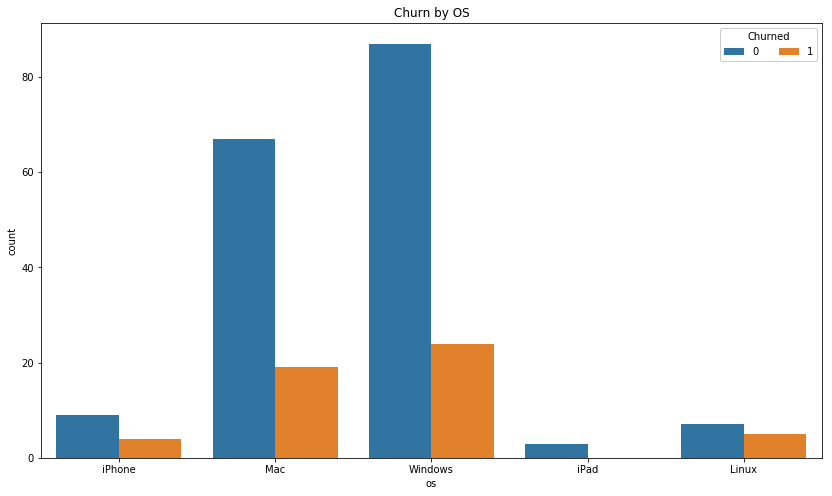

In [45]:
plt.figure(figsize=[14,8])
sns.countplot(data = df_os, x = 'os', hue ='Churned')
plt.title('Churn by OS')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'Churned');

In [46]:
for value in df_os["os"].unique():
    churns = len(df_os[(df_os["os"]==value) & (df_os["Churned"]==1)])
    total = len(df_os[df_os["os"]==value])
    churn_rate = churns / total
    print(f"The Churn Rate for {value} is {churn_rate}")

The Churn Rate for iPhone is 0.3076923076923077
The Churn Rate for Mac is 0.22093023255813954
The Churn Rate for Windows is 0.21621621621621623
The Churn Rate for iPad is 0.0
The Churn Rate for Linux is 0.4166666666666667


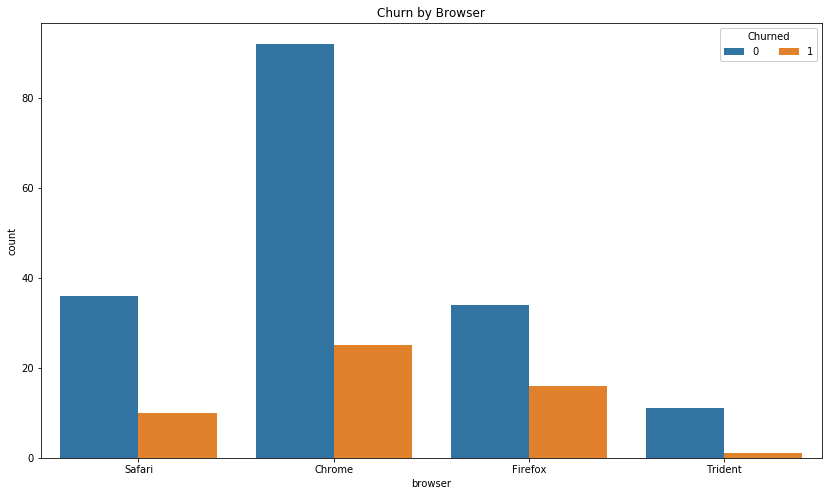

In [47]:
plt.figure(figsize=[14,8])
sns.countplot(data = df_os, x = 'browser', hue ='Churned')
plt.title('Churn by Browser')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'Churned');

In [48]:
for value in df_os["browser"].unique():
    churns = len(df_os[(df_os["browser"]==value) & (df_os["Churned"]==1)])
    total = len(df_os[df_os["browser"]==value])
    churn_rate = churns / total
    print(f"The Churn Rate for {value} is {churn_rate}")

The Churn Rate for Safari is 0.21739130434782608
The Churn Rate for Chrome is 0.21367521367521367
The Churn Rate for Firefox is 0.32
The Churn Rate for Trident is 0.08333333333333333


### Churn by Location 

Here we analyse the churns based on a users location

In [49]:
event_data.select('location').distinct().show(10)

+--------------------+
|            location|
+--------------------+
|Atlantic City-Ham...|
|     Gainesville, FL|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
+--------------------+
only showing top 10 rows



In [50]:
# udf function for extracting the state of the location
get_state = udf(lambda x: x[-2:])

In [51]:
# create a new column with the state
event_data = event_data.withColumn("state", get_state(event_data.location))

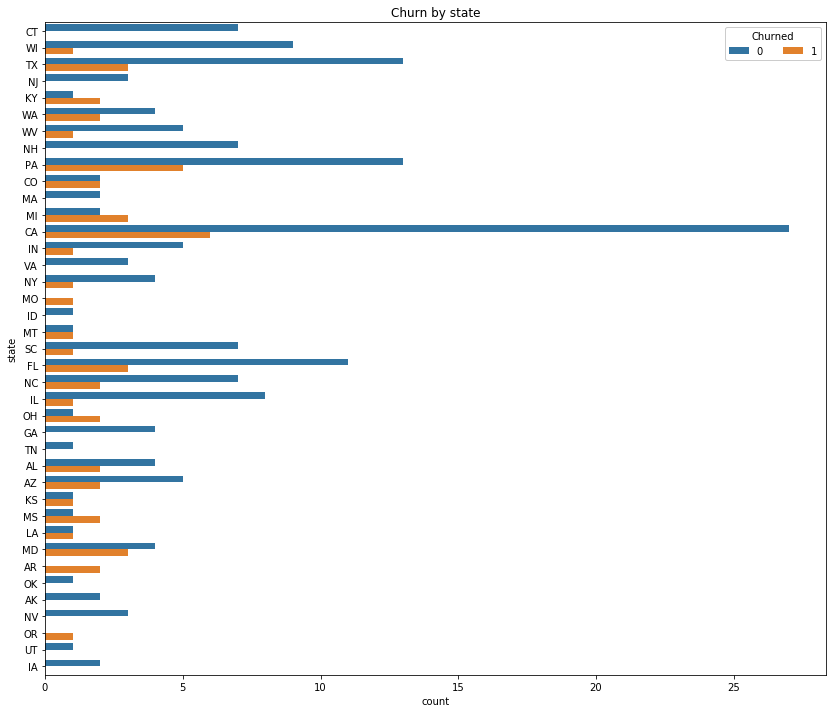

In [52]:
df_state = event_data.select("userId", "state", "Churned").dropDuplicates(['userId'])
# convert to pandas
df = df_state.toPandas()

#graph for churn by state
plt.figure(figsize=[14,12])
sns.countplot(data = df, y = 'state', hue ='Churned')
plt.title('Churn by state')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'Churned');

### Churn by User Actions

Here we want to analyse the churns based on the user's actions and thereby analyzing the user engegement.

In [53]:
df_pages = event_data.select("userId", "page", "Churned").groupBy("userId",'page','Churned').count()

In [54]:
df_pages = df_pages.groupBy("page", "Churned").agg(avg("count").alias("mean_count"))

In [55]:
df = df_pages.toPandas()

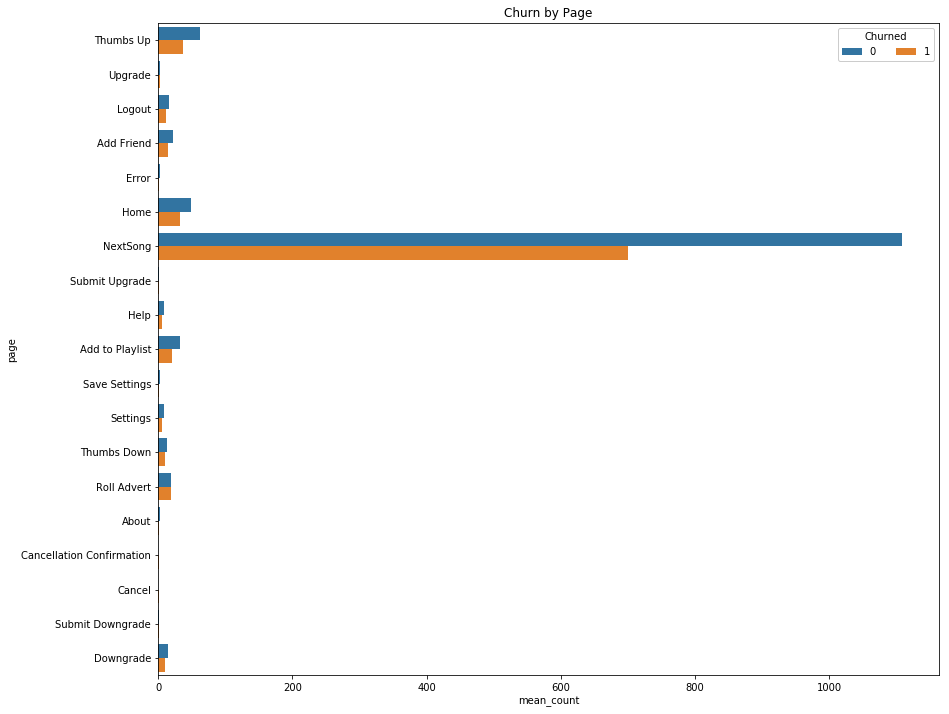

In [56]:
#graph for churn by state
plt.figure(figsize=[14,12])
sns.barplot(data = df, x="mean_count", y = 'page', hue ='Churned')
plt.title('Churn by Page')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'Churned');

In general we can see here that users with lower interaction have a higher churn rate.

### Churn by Mean Session Length

In [57]:
df_session = event_data.select("sessionId", "Churned", "length") \
            .groupBy('sessionId','Churned') \
            .agg(avg("length").alias("mean_session_length"))

In [58]:
df_session = df_session.groupBy("Churned").agg(avg("mean_session_length").alias("mean_session_length"))

In [59]:
df_session.show()

+-------+-------------------+
|Churned|mean_session_length|
+-------+-------------------+
|      1|  248.6136076433262|
|      0|  248.6536646755348|
+-------+-------------------+



No significant difference in session length for users who have churned and who did not.

### Churn by Songs per Session

In [60]:
df_songs = event_data.filter(event_data.page == "NextSong").dropDuplicates().groupBy('sessionId','Churned').count()

In [61]:
# get average grouped by churn
df_songs.groupby('Churned').agg({"count":"avg"}).show()

+-------+-----------------+
|Churned|       avg(count)|
+-------+-----------------+
|      1|79.81140350877193|
|      0| 93.3369036027264|
+-------+-----------------+



### Churn by Time between registration and last session

In [62]:
df_delta = event_data.select(['userId', 'registration', 'ts', 'Churned']).dropDuplicates().sort('userId')

In [63]:
# order by last timestamp
w = Window.partitionBy("userId")

In [64]:
#create column for maximum timestamp per userid
df_delta = df_delta.withColumn("max_timestamp", max("ts").over(w))

In [65]:
# create column with delta between registration and max timestamp 
df_delta = df_delta.withColumn("delta", (df_delta['max_timestamp']) - (df_delta['registration']))

In [66]:
df_delta.show()

+------+-------------+-------------+-------+-------------+----------+
|userId| registration|           ts|Churned|max_timestamp|     delta|
+------+-------------+-------------+-------+-------------+----------+
|    10|1538159495000|1538965220000|      0|1542631788000|4472293000|
|    10|1538159495000|1538965485000|      0|1542631788000|4472293000|
|    10|1538159495000|1538965685000|      0|1542631788000|4472293000|
|    10|1538159495000|1538965893000|      0|1542631788000|4472293000|
|    10|1538159495000|1538966419000|      0|1542631788000|4472293000|
|    10|1538159495000|1538966691000|      0|1542631788000|4472293000|
|    10|1538159495000|1538966898000|      0|1542631788000|4472293000|
|    10|1538159495000|1538966899000|      0|1542631788000|4472293000|
|    10|1538159495000|1538967004000|      0|1542631788000|4472293000|
|    10|1538159495000|1538967243000|      0|1542631788000|4472293000|
|    10|1538159495000|1538967507000|      0|1542631788000|4472293000|
|    10|153815949500

In [67]:
df_delta = df_delta.withColumn('delta_in_days',(df_delta['delta']/1000/3600/24))

In [68]:
# to Pandas for the plot
df_delta_pd = df_delta.toPandas()

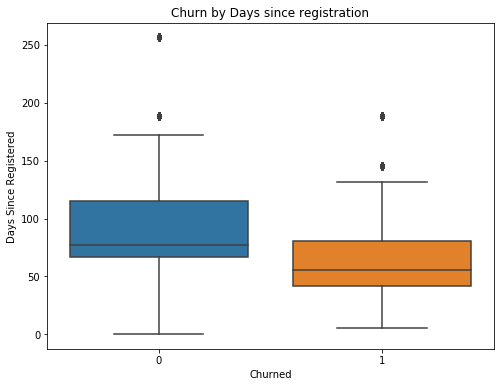

In [69]:
# plot boxplot
plt.figure(figsize=[8,6])
sns.boxplot(data = df_delta_pd, x = 'Churned', y ='delta_in_days')
plt.title('Churn by Days since registration')
plt.ylabel("Days Since Registered");

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Approach

For the machine learning model we will create the following features:

Categorical:

 + gender
 + most used operating system
 + level

Numerical:

+ number of songs per session
+ number of add to playlist actions
+ number of thumbs down actions
+ number of thumbs up actions
+ number of friends added actions
+ number of distinct artists listened to
+ number of days since registering

The variable to be predicted will be churned.

#### Gender

Create initial dataframe that will be used for the ML model by only including the userid, the gender and if the user has churned or not. The other features will later be added to this dataframe.

In [70]:
#starting dataframe for modelling
df = event_data.select("userId", "gender", "Churned").dropDuplicates()

In [71]:
# create categorical gender column 
df = df.withColumn('gender', when(df['gender'] == 'F', 1).otherwise(0))

#### Level

Create categorical variable per user for latest subscription level i.e. the level of subscription (paid or free with ads) each user has had in his last visible session.

In [72]:
#create dataframe for finding the level for the last timestamp
df_level = event_data.select("userId", "level", "ts").dropDuplicates().sort("userId")

In [73]:
w = Window.partitionBy("userId").orderBy(desc("ts"))

In [74]:
df_level = df_level.withColumn("ranking", dense_rank().over(w))

In [75]:
df_level = df_level.filter(df_level["ranking"]==1).drop("ranking", "ts")

In [76]:
#join to main dataframe
df = df.join(df_level, on="userId", how="left")

In [77]:
# create categorical level column 
df = df.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))

#### Operating System

Create categorical variable that determines which operating system the user used most frequently

In [78]:
#create dataframe for finding the most frequently used operating system
df_os = event_data.select("userId", "userAgent", "sessionId").dropDuplicates()

In [79]:
#extract the os information from the userAgent column

# Construct the regular expression pattern using the os_list
pattern = '(?i)({0})'.format('|'.join(os_list))

# Add a new column "os" containing the extracted operating system information
df_os = df_os.withColumn("os", regexp_extract(col("userAgent"), pattern, 1))

In [80]:
df_os = df_os.groupBy("userId", "os").count().sort("userId")

In [81]:
w = Window.partitionBy("userId").orderBy(desc("count"))

In [82]:
df_os = df_os.withColumn("ranking", dense_rank().over(w))

In [83]:
df_os = df_os.filter(df_os["ranking"]==1).drop("count")

In [84]:
# create categorical column for different operating systems
df_os = df_os.withColumn('os_Mac', when(col('os') == 'Mac', 1).otherwise(0))
df_os = df_os.withColumn('os_Linux', when(col('os') == 'Linux', 1).otherwise(0))
df_os = df_os.withColumn('os_Windows', when(col('os') == 'Windows', 1).otherwise(0))
df_os = df_os.withColumn('os_iPhone', when(col('os') == 'iPhone', 1).otherwise(0))
df_os = df_os.withColumn('os_iPad', when(col('os') == 'iPad', 1).otherwise(0))

In [85]:
#drop the os and ranking column
df_os = df_os.drop("os", "ranking")

In [86]:
#join to main dataframe
df = df.join(df_os, on="userId", how="left")

#### Number of Songs per Session

Create nummerical variable with mean number of songs per season per user

In [87]:
df_songs = event_data.filter(event_data["page"]=="NextSong").groupBy("userId", "sessionId").count()

In [88]:
df_songs = df_songs.groupBy("userId").agg(avg("count").alias("mean_songs_per_session"))

In [89]:
#join to main dataframe
df = df.join(df_songs, on="userId", how="left")

#### Number of add to playlist actions

Create nummerical variable with number of add to playlist actions

In [90]:
df_add = event_data.filter(event_data["page"]=="Add to Playlist").groupBy("userId").count()

In [91]:
df_add = df_add.withColumn("number_add_playlist_actions", 
                                   when(col("count").isNull(), 0).otherwise(col("count"))).drop("count")

In [92]:
#join to main dataframe
df = df.join(df_add, on="userId", how="left")

#### Number of thumbs down actions

Create nummerical variable with number of thumbs down actions per user

In [93]:
df_down = event_data.filter(event_data["page"]=="Thumbs Down").groupBy("userId").count()

In [94]:
df_down = df_down.withColumn("number_thumbs_down_actions", 
                                   when(col("count").isNull(), 0).otherwise(col("count"))).drop("count")

In [95]:
#join to main dataframe
df = df.join(df_down, on="userId", how="left")

#### Number of thumbs up actions

Create nummerical variable with number of thumbs up actions per user

In [96]:
df_up = event_data.filter(event_data["page"]=="Thumbs Up").groupBy("userId").count()

In [97]:
df_up = df_up.withColumn("number_thumbs_up_actions", 
                                   when(col("count").isNull(), 0).otherwise(col("count"))).drop("count")

In [98]:
#join to main dataframe
df = df.join(df_up, on="userId", how="left")

#### Number of friends add actions

Create nummerical variable with number of friends adding actions per user

In [99]:
df_friend = event_data.filter(event_data["page"]=="Add Friends").groupBy("userId").count()

In [100]:
df_friend = df_friend.withColumn("number_add_friend_actions", 
                                   when(col("count").isNull(), 0).otherwise(col("count"))).drop("count")

In [101]:
#join to main dataframe
df = df.join(df_friend, on="userId", how="left")

#### Number of Distinct Artists

Create nummerical variable with number of distinct artists listened to per user

In [102]:
df_artists = event_data.select("userId", "artist").dropDuplicates().groupBy("userId").count()

In [103]:
df_artists = df_artists.withColumn("number_distinct_artists", 
                                   when(col("count").isNull(), 0).otherwise(col("count"))).drop("count")

In [104]:
#join to main dataframe
df = df.join(df_artists, on="userId", how="left")

#### Number of Days since registering

Create nummerical variable with the number of days that passed since registering

In [105]:
#using the already created df_delta dataframe for the days since registering
w = Window.partitionBy("userId").orderBy(desc("ts"))

df_delta = df_delta.withColumn("ranking", dense_rank().over(w))

In [106]:
df_delta = df_delta.filter(df_delta["ranking"]==1)

In [107]:
df_delta = df_delta.select("userId", "delta_in_days")

In [108]:
#join to main dataframe
df = df.join(df_delta, on="userId", how="left")

In [109]:
#set all the null values to 0
for col in df.columns:
    df = df.withColumn(col, when(df[col].isNull(), 0).otherwise(df[col]))

In [110]:
# drop the userid column
df = df.drop("userId")

In [111]:
df.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- Churned: integer (nullable = true)
 |-- level: integer (nullable = false)
 |-- os_Mac: integer (nullable = true)
 |-- os_Linux: integer (nullable = true)
 |-- os_Windows: integer (nullable = true)
 |-- os_iPhone: integer (nullable = true)
 |-- os_iPad: integer (nullable = true)
 |-- mean_songs_per_session: double (nullable = true)
 |-- number_add_playlist_actions: long (nullable = true)
 |-- number_thumbs_down_actions: long (nullable = true)
 |-- number_thumbs_up_actions: long (nullable = true)
 |-- number_add_friend_actions: long (nullable = true)
 |-- number_distinct_artists: long (nullable = true)
 |-- delta_in_days: double (nullable = true)



In [112]:
#convert every column into nummerical datatypes
for col in df.columns:
    df = df.withColumn(col, df[col].cast('float'))

In [113]:
df = df.withColumnRenamed("Churned", "label")

### vector assembler & standardization

the vector assembler transforms all the columns into vectors so they can be standardized in the next step

In [114]:
assembler = VectorAssembler(inputCols = ["gender", "level", "os_Mac", "os_Linux", "os_Windows", "os_iPhone", \
                                         "os_iPad", "mean_songs_per_session", "number_add_playlist_actions", \
                                         "number_thumbs_down_actions", "number_thumbs_up_actions", "number_add_friend_actions", \
                                        "number_distinct_artists", "delta_in_days"],  outputCol = "vec_features")

In [115]:
vectorized_df = assembler.transform(df)

In [116]:
scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd=True)

In [117]:
scaler_model = scaler.fit(vectorized_df)

In [118]:
scaled_df = scaler_model.transform(vectorized_df)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Train Test Split
we now split our dataframe in train, test and validation datasets

In [119]:
train, test, valid = scaled_df.randomSplit([0.6, 0.2, 0.2], seed = 42)
print("The Training Dataset has a lenght of: " + str(train.count()))
print("The Test Dataset has a length of: " + str(test.count()))
print("The Validation Dataset has a lenght of: " + str(valid.count()))

The Training Dataset has a lenght of: 142
The Test Dataset has a length of: 49
The Validation Dataset has a lenght of: 34


### Model training and evaluation

we select 4 different ML classifiers to be trained and evaluated and then continue with the most promising one for the further optimization.

In [120]:
# instantiation of 5 different models
log_reg = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10, seed=42)
naive_bayes = NaiveBayes(featuresCol = 'features', labelCol = 'label')
random_forrest = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=42)

In [121]:
#list of models
model_list = [log_reg, gbt, naive_bayes, random_forrest]

#model_list = [random_forrest]

In [122]:
# usage of multiclassclassificationevaluator 
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

Evaluation of ML models with f1-score and accuracy.

Accuracy: It measures the proportion of correctly predicted instances (both true positives and true negatives) out of the total instances. While accuracy is important, it might not be the best metric when dealing with imbalanced datasets where one class significantly outnumbers the other. In such cases, accuracy might be misleading as a high accuracy can be achieved by simply predicting the majority class.

F1 Score: It is the harmonic mean of precision and recall. F1 score provides a balance between precision (the proportion of correctly predicted positive instances out of all predicted positive instances) and recall (the proportion of correctly predicted positive instances out of all actual positive instances). F1 score is particularly useful when dealing with imbalanced datasets as it considers both false positives and false negatives.

That is why in the case of this dataset the f1-score is better for evaluating the models.

In [123]:
model_names = []
train_times = []
f1_scores = []
accuracies = []

for model in model_list:
    # get model name
    model_name = model.__class__.__name__
    model_names.append(model_name)
    
    #set start time for model training
    start_time = time.time()
    print(f"For the {model_name} model the training has started")
    
    #fit model
    model = model.fit(train)
    
    #predict values
    pred = model.transform(valid)
    
    #set end time for model training
    end_time = time.time()
    print(f"For the {model_name} model the training has ended")
    train_time = end_time - start_time
    train_times.append(train_time)
    print(f"For the {model_name} model, the training took {train_time} seconds")
    
    # calculate f1 score
    f1_score = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    print(f"For the model {model_name} the f1-score is {f1_score}")
    f1_scores.append(f1_score)
    
    # calculate accuracy
    acc = pred.filter(pred.label == pred.prediction).count() / (pred.count())
    print(f"For the model {model_name} the accuracy is {acc}")
    accuracies.append(acc)

For the LogisticRegression model the training has started
For the LogisticRegression model the training has ended
For the LogisticRegression model, the training took 347.4583308696747 seconds
For the model LogisticRegression the f1-score is 0.5707013574660633
For the model LogisticRegression the accuracy is 0.6470588235294118
For the GBTClassifier model the training has started
For the GBTClassifier model the training has ended
For the GBTClassifier model, the training took 407.00588512420654 seconds
For the model GBTClassifier the f1-score is 0.6161764705882353
For the model GBTClassifier the accuracy is 0.6470588235294118
For the NaiveBayes model the training has started
For the NaiveBayes model the training has ended
For the NaiveBayes model, the training took 291.0699932575226 seconds
For the model NaiveBayes the f1-score is 0.5745245466607696
For the model NaiveBayes the accuracy is 0.6176470588235294
For the RandomForestClassifier model the training has started
For the RandomFore

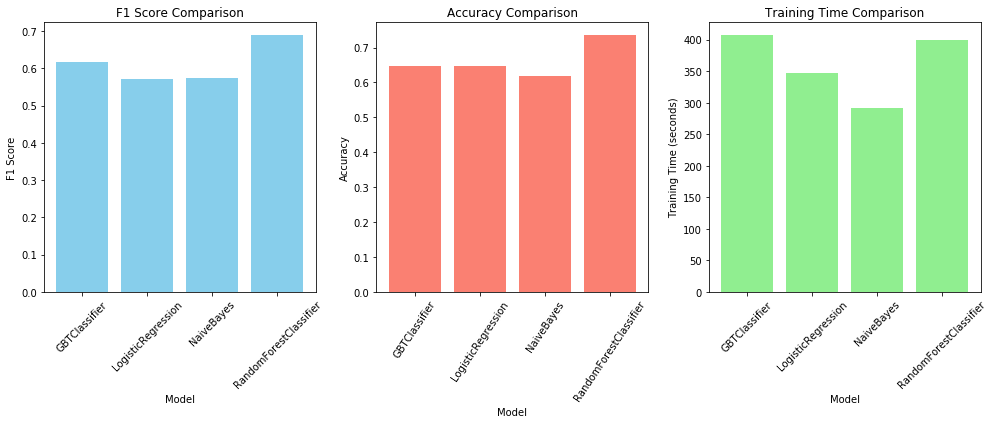

In [124]:
#plotting the results for the different models

# Plotting f1 scores
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.bar(model_names, f1_scores, color='skyblue')
plt.title('F1 Score Comparison')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)

# Plotting accuracies
plt.subplot(1, 3, 2)
plt.bar(model_names, accuracies, color='salmon')
plt.title('Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=56)


# Plotting training times
plt.subplot(1, 3, 3)
plt.bar(model_names, train_times, color='lightgreen')
plt.title('Training Time Comparison')
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Model optimization

We will now further tweak the parameters of our most performant model, which in our case is the random forrest model with a f1-score of 0,68 and a training time of about 400 seconds.

In [127]:
paramGrid = ParamGridBuilder() \
    .addGrid(random_forrest.numTrees,[10, 20, 50]) \
    .addGrid(random_forrest.maxDepth,[5, 10, 15]) \
    .build()


cv = CrossValidator(estimator=random_forrest,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=3)

In [128]:
cv_model = cv.fit(train)

In [129]:
cv_model.avgMetrics

[0.7828084159504247,
 0.7737434068854157,
 0.7686190501659838,
 0.7584142571376613,
 0.7495087330799692,
 0.7495087330799692,
 0.7261129457522815,
 0.7246539509750791,
 0.7246539509750791]

In [130]:
predictions = cv_model.transform(valid)

In [131]:
best_model = cv_model.bestModel

In [132]:
print ("The best parameter for the hyperparameter numTrees is: ", best_model._java_obj.getNumTrees())
print ("The best parameter for the hyperparameter MaxDepth is: ", best_model._java_obj.getMaxDepth())

The best parameter for the hyperparameter numTrees is:  10
The best parameter for the hyperparameter MaxDepth is:  5


In [133]:
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print(f"The f1-score for the best parameters is {f1}")

The f1-score for the best parameters is 0.6193771626297577


In [134]:
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(f"The accuracy for the best parameters is {accuracy}")

The accuracy for the best parameters is 0.6764705882352942


The results of the cross validation show that the f1-score actually decreased. The possible explanation for that is the occurrence of overfitting in the orgiginal model. 
Overfitting occurs when a machine learning model learns to capture the noise in the training data rather than the underlying pattern, leading to poor generalization to unseen data. Several factors can contribute to overfitting:

-Too many features: Including a large number of irrelevant or redundant features in the model can lead to overfitting. These features add noise to the model and can cause it to learn patterns that are specific to the training data but do not generalize well to new data.

-Complexity of the model: Using a highly complex model with a large number of parameters can increase the risk of overfitting. Complex models have high capacity to learn intricate patterns in the training data, including noise, which may not generalize well to new data.

In our case we could decrease the number of features and see if the f1 score increases after crossvalidation.

### Checking for the importance per feature

In [135]:
feat_importance = best_model.featureImportances

In [136]:
x = list(range(len(feat_importance)))

In [137]:
feat_list = list(["gender", "level", "os_Mac", "os_Linux", "os_Windows", "os_iPhone", \
                                         "os_iPad", "mean_songs_per_session", "number_add_playlist_actions", \
                                         "number_thumbs_down_actions", "number_thumbs_up_actions", "number_add_friend_actions", \
                                         "number_distinct_artists", "delta_in_days"])

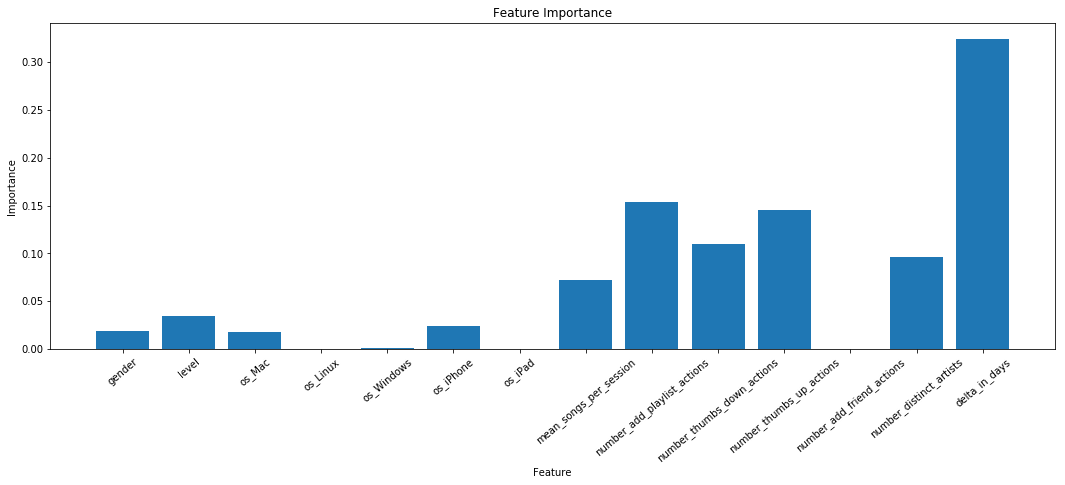

In [138]:
plt.figure(figsize=[18,6])
plt.bar(x, feat_importance, orientation = 'vertical')
plt.xticks(x, feat_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importance');

In [139]:
feat_importance

SparseVector(14, {0: 0.0189, 1: 0.0349, 2: 0.018, 4: 0.0012, 5: 0.0247, 7: 0.0723, 8: 0.1536, 9: 0.1101, 10: 0.1456, 12: 0.0961, 13: 0.3245})

## Conclusion

In this project we worked with a small dataset of 128 MB with usage data for a subscription services similar to spotify or apple music. We first analysed the data to further understand it and in order to work with it. We then cleaned it so it could be processed. We then dove into feature engineering to derive the features that would have a good impact on predicting the subscription churns. We then trained different machine learning models to predict those churns. The most promising machine learning model was the random forrest classifier with an accuracy of ... and an f1 score of ...

### Room for improvement

+ Since in this case only a small subset of the data was used, a better model could be developed with the whole 12GB dataset
+ The overfitting problem would need to be looked at by overdoing the feature enigineering part and dismissing a couple of variables